# Evolution of Persona 1 within the two quarters¶

In [1]:
# Remove the warnings for presentation of the notebook. During the development, the warnings were not ignored.
import warnings
warnings.filterwarnings('ignore')

Some part of this calculation will use pyspark, namely the creation of the clickstream. So first, the pyspark and other dependent libraries must be imported and spark session must be inisiated.

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc =SparkContext()
spark = SparkSession(sc)

csQ4 = spark.read.format('csv').option('header', True).load('iteration-2-clickstream-Q4.csv')
csQ1 = spark.read.format('csv').option('header', True).load('iteration-2-clickstream-Q1.csv')

csQ4_pd = csQ4.toPandas()
csQ1_pd = csQ1.toPandas()

## Clickstream

Then, the below calculation is done to find each user session. More on this can be found on the technical paper. This specific line below will concate the type of activity and the page location of the user activities in Q4 as a result.

In [3]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *

windowSpec  = Window.partitionBy("userID").orderBy("timestamp")
dfQ4_1 = csQ4.withColumn("lagvalue", lag('timestamp', 1).over(windowSpec))
dfQ4_2 = dfQ4_1.withColumn('tsDiff', (unix_timestamp('timestamp') - unix_timestamp('lagvalue')))
dfQ4_3 = dfQ4_2.withColumn('tsDiff', when(col('tsDiff').isNull(), 0).otherwise(col('tsDiff')))
dfQ4_4 = dfQ4_3.withColumn('SessionNew', when(col('tsDiff') > 10800, 1).otherwise(0))
dfQ4_5 = dfQ4_4.withColumn('SessionName', concat(('userID'), lit('+Session-'), sum('SessionNew').over(windowSpec)))
dfQ4_6 = dfQ4_5.withColumn('pageActivity', concat(('activity_og'), lit('-'), ('page')))
dfQ4_6.show()

+-----+------+-------+-------------------+-----------+--------------------+-------------------+------+----------+--------------+--------------------+
|  _c0|userID|cluster|          timestamp|activity_og|                page|           lagvalue|tsDiff|SessionNew|   SessionName|        pageActivity|
+-----+------+-------+-------------------+-----------+--------------------+-------------------+------+----------+--------------+--------------------+
|65356|   125|      3|2020-10-01 03:37:57|       Page|https://en.wikipe...|               null|     0|         0| 125+Session-0|Page-https://en.w...|
|25702|   125|      0|2020-10-01 19:12:29|       Page|https://en.wikipe...|2020-10-01 03:37:57| 56072|         1| 125+Session-1|Page-https://en.w...|
|34911|   125|      0|2020-10-01 22:19:18|      Event|https://en.wikipe...|2020-10-01 19:12:29| 11209|         1| 125+Session-2|Event-https://en....|
|56348|   125|      3|2020-10-02 01:20:49|      Event|https://en.wikipe...|2020-10-01 22:19:18| 1089

This specific line below will concate the type of activity and the page location of the user activities in Q1 as a result.

In [4]:
windowSpec1  = Window.partitionBy("userID").orderBy("timestamp")
dfQ1_1 = csQ1.withColumn("lagvalue", lag('timestamp', 1).over(windowSpec1))
dfQ1_2 = dfQ1_1.withColumn('tsDiff', (unix_timestamp('timestamp') - unix_timestamp('lagvalue')))
dfQ1_3 = dfQ1_2.withColumn('tsDiff', when(col('tsDiff').isNull(), 0).otherwise(col('tsDiff')))
dfQ1_4 = dfQ1_3.withColumn('SessionNew', when(col('tsDiff') > 10800, 1).otherwise(0))
dfQ1_5 = dfQ1_4.withColumn('SessionName', concat(('userID'), lit('+Session-'), sum('SessionNew').over(windowSpec1)))
dfQ1_6 = dfQ1_5.withColumn('pageActivity', concat(('activity_og'), lit('-'), ('page')))
dfQ1_6.show()

+-----+------+-------+-------------------+-----------+--------------------+-------------------+------+----------+-------------+--------------------+
|  _c0|userID|cluster|          timestamp|activity_og|                page|           lagvalue|tsDiff|SessionNew|  SessionName|        pageActivity|
+-----+------+-------+-------------------+-----------+--------------------+-------------------+------+----------+-------------+--------------------+
|33263|   125|      0|2021-01-01 01:08:28|       Page|https://en.wikipe...|               null|     0|         0|125+Session-0|Page-https://en.w...|
|79974|   125|      1|2021-01-01 12:59:58|       Page|https://en.wikipe...|2021-01-01 01:08:28| 42690|         1|125+Session-1|Page-https://en.w...|
|28580|   125|      0|2021-01-01 14:31:31|      Event|https://en.wikipe...|2021-01-01 12:59:58|  5493|         0|125+Session-1|Event-https://en....|
|43547|   125|      0|2021-01-01 15:32:52|      Event|https://en.wikipe...|2021-01-01 14:31:31|  3681|    

Before turning them into clickstream, each dataframe is broken down further into each personas.

In [5]:
personaQ4_1_stream = dfQ4_6.filter(dfQ4_6['cluster'] == '0')
personaQ4_2_stream = dfQ4_6.filter(dfQ4_6['cluster'] == '1')
personaQ4_3_stream = dfQ4_6.filter(dfQ4_6['cluster'] == '2')
personaQ4_4_stream = dfQ4_6.filter(dfQ4_6['cluster'] == '3')
personaQ4_1_stream

DataFrame[_c0: string, userID: string, cluster: string, timestamp: string, activity_og: string, page: string, lagvalue: string, tsDiff: bigint, SessionNew: int, SessionName: string, pageActivity: string]

In [6]:
personaQ1_1_stream = dfQ1_6.filter(dfQ1_6['cluster'] == '0')
personaQ1_2_stream = dfQ1_6.filter(dfQ1_6['cluster'] == '1')
personaQ1_3_stream = dfQ1_6.filter(dfQ1_6['cluster'] == '2')
personaQ1_4_stream = dfQ1_6.filter(dfQ1_6['cluster'] == '3')
personaQ1_1_stream

DataFrame[_c0: string, userID: string, cluster: string, timestamp: string, activity_og: string, page: string, lagvalue: string, tsDiff: bigint, SessionNew: int, SessionName: string, pageActivity: string]

Now, pyspark is used to process the clickstream of Q4 using group by and aggregate function. There are 3 types of clickstream created. Combination of page and activity, just the page, and just the activity. Lastly, the count of activity per page was calculated as well. 
<br><br>
<b style="color: red">From this calculation on until the end of the section, the calculation is only for the first persona. Notice the _1 in the variable name</b>

In [7]:
import pyspark.sql.functions as f
import pandas as pd

dfPQ4_1 = personaQ4_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ4_1_stream.pageActivity)))
dfPQ4_1 = dfPQ4_1.groupby('concat_ws(> , collect_list(pageActivity))').count()
dfPQ4_1 = dfPQ4_1.sort(col('count').desc())
dfPQ4_1 = dfPQ4_1.toPandas()

dfPQ4_1a = personaQ4_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ4_1_stream.page)))
dfPQ4_1a = dfPQ4_1a.groupby('concat_ws(> , collect_list(page))').count()
dfPQ4_1a = dfPQ4_1a.sort(col('count').desc())
dfPQ4_1a = dfPQ4_1a.toPandas()

dfPQ4_1b = personaQ4_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ4_1_stream.activity_og)))
dfPQ4_1b = dfPQ4_1b.groupby('concat_ws(> , collect_list(activity_og))').count()
dfPQ4_1b = dfPQ4_1b.sort(col('count').desc())
dfPQ4_1b = dfPQ4_1b.toPandas()

dfPQ4_1c = personaQ4_1_stream[personaQ4_1_stream['activity_og'] == 'Event']
dfPQ4_1c = dfPQ4_1c.groupby('page').count()
dfPQ4_1c = dfPQ4_1c.toPandas()

The below algorithms are the same as above, but using Q1 dataframe.

In [8]:
dfPQ1_1 = personaQ1_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ1_1_stream.pageActivity)))
dfPQ1_1 = dfPQ1_1.groupby('concat_ws(> , collect_list(pageActivity))').count()
dfPQ1_1 = dfPQ1_1.sort(col('count').desc())
dfPQ1_1 = dfPQ1_1.toPandas()

dfPQ1_1a = personaQ1_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ1_1_stream.page)))
dfPQ1_1a = dfPQ1_1a.groupby('concat_ws(> , collect_list(page))').count()
dfPQ1_1a = dfPQ1_1a.sort(col('count').desc())
dfPQ1_1a = dfPQ1_1a.toPandas()

dfPQ1_1b = personaQ1_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ1_1_stream.activity_og)))
dfPQ1_1b = dfPQ1_1b.groupby('concat_ws(> , collect_list(activity_og))').count()
dfPQ1_1b = dfPQ1_1b.sort(col('count').desc())
dfPQ1_1b = dfPQ1_1b.toPandas()

dfPQ1_1c = personaQ1_1_stream[personaQ1_1_stream['activity_og'] == 'Event']
dfPQ1_1c = dfPQ1_1c.groupby('page').count()
dfPQ1_1c = dfPQ1_1c.toPandas()

## Persona group size
The below cell calculates the magnitude of each persona both in number and in percentage. Then, it calculates the difference from Q4 to Q1

In [9]:
import numpy as np

cardinality_df_Q4 = pd.DataFrame(csQ4_pd['cluster'].value_counts().reset_index())
cardinality_df_Q4.rename(columns={
    'index': 'Persona',
    'cluster': 'Magnitude_Q4'
}, inplace=True)
cardinality_df_Q4['MagnitudeInPercentage_Q4'] = cardinality_df_Q4['Magnitude_Q4'] /cardinality_df_Q4['Magnitude_Q4'].sum() * 100
cardinality_df_Q4['MagnitudeInPercentage_Q4'] = np.ceil(cardinality_df_Q4['MagnitudeInPercentage_Q4'])
cardinality_df_Q4

cardinality_df_Q1 = pd.DataFrame(csQ1_pd['cluster'].value_counts().reset_index())
cardinality_df_Q1.rename(columns={
    'index': 'Persona',
    'cluster': 'Magnitude_Q1'
}, inplace=True)
cardinality_df_Q1['MagnitudeInPercentage_Q1'] = cardinality_df_Q1['Magnitude_Q1'] /cardinality_df_Q1['Magnitude_Q1'].sum() * 100
cardinality_df_Q1['MagnitudeInPercentage_Q1'] = np.ceil(cardinality_df_Q1['MagnitudeInPercentage_Q1'])
cardinality_df_Q1

,Persona,Magnitude_Q1,MagnitudeInPercentage_Q1
0,3,25352,26.0
1,0,25334,26.0
2,1,25233,25.0
3,2,25182,25.0


In [10]:
size = cardinality_df_Q1.merge(cardinality_df_Q4, on='Persona')
size.head()

,Persona,Magnitude_Q1,MagnitudeInPercentage_Q1,Magnitude_Q4,MagnitudeInPercentage_Q4
0,3,25352,26.0,25048,26.0
1,0,25334,26.0,25084,26.0
2,1,25233,25.0,24893,25.0
3,2,25182,25.0,24975,25.0


## Visualization
The below section consists of the visualization of the above calculations.

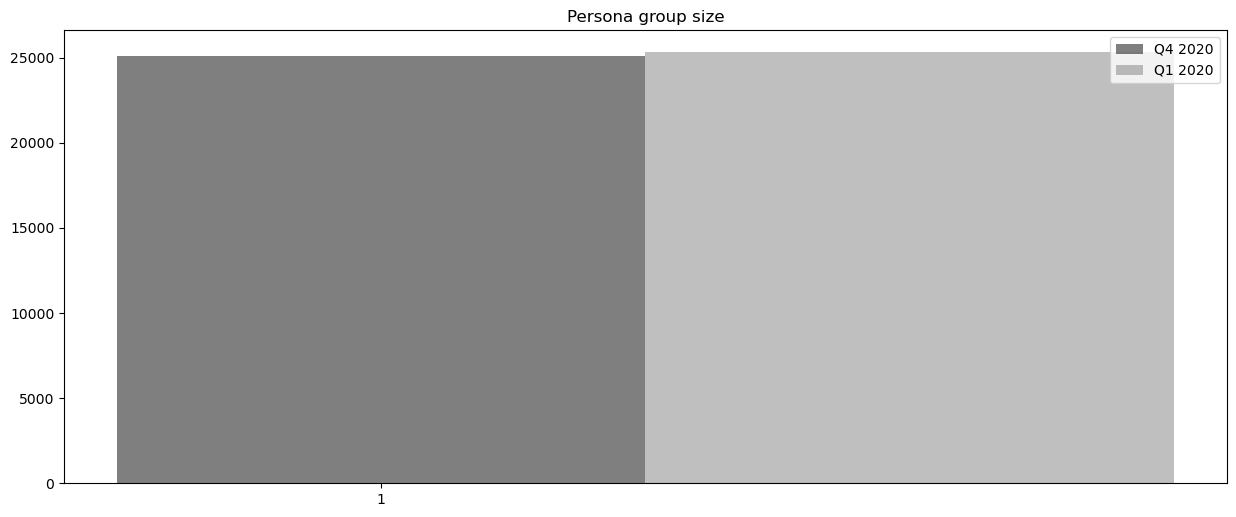

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})

size['Persona'] = size['Persona'].astype(int) + 1
persona1 = size[size['Persona'] == 1]
x1_axis_labels = persona1['Persona'].sort_values().tolist()
y1_axis_values = persona1['Magnitude_Q4'].tolist()
x2_axis_labels = persona1['Persona'].sort_values().tolist()
y2_axis_values = persona1['Magnitude_Q1'].tolist()

y1_pos=np.arange(len(x1_axis_labels))
y2_pos=np.arange(len(x2_axis_labels))

kwargs = dict(alpha=0.5)

plt.bar(y1_pos + 0, y1_axis_values, **kwargs, width=0.15, color = 'black', label='Q4 2020')
plt.bar(y2_pos + 0.15, y2_axis_values, **kwargs, width=0.15, color = 'grey', label='Q1 2020')

plt.xticks(y1_pos, x1_axis_labels)
plt.xticks(y2_pos, x2_axis_labels)

plt.legend(loc='best')
plt.title("Persona group size")
plt.show()


## Visit history

<b style="color: red">This section consists of the visualization of the visit history of persona 1 (in code, the caluclation always started with 0. Thus persona 1 is cluster 0). It's not specified in the variable name, however filtered in the below cell.</b>

In [12]:
dfQ4 = pd.read_csv('visit-history-Q4.csv')
dfQ1 = pd.read_csv('visit-history-Q1.csv')

dfQ4 = dfQ4[dfQ4['cluster'] == 0]
dfQ1 = dfQ1[dfQ1['cluster'] == 0]
dfQ4.head()

,Unnamed: 0,userID,index,visitByTheHour,weekOfYear,weekOfYear.1,dayOfWeek,cluster
24975,24975,183,24975,0,44,44,5,0
24976,24976,24,24976,17,51,51,6,0
24977,24977,139,24977,20,39,39,5,0
24978,24978,164,24978,13,41,41,6,0
24979,24979,12,24979,10,48,48,5,0


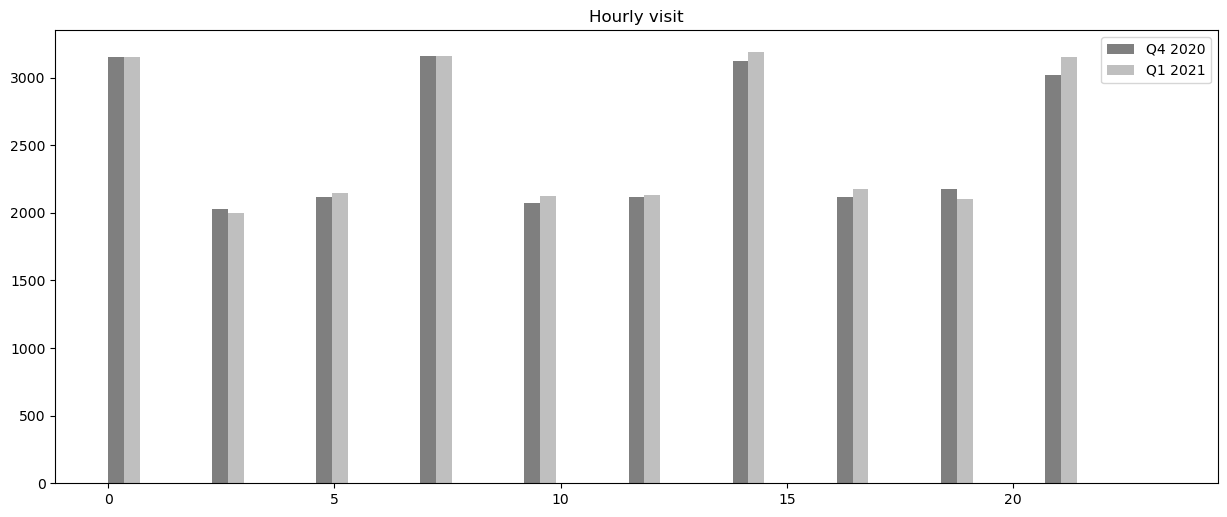

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})

x1 = dfQ4['visitByTheHour']
x2 = dfQ1['visitByTheHour']
kwargs = dict(alpha=0.5)

plt.hist(x1, **kwargs, label='Q4 2020', width=0.35, color='black')
plt.hist(x2 + 0.35, **kwargs, label='Q1 2021', width=0.35, color='grey')
plt.gca().set(title='Hourly visit')

plt.legend();

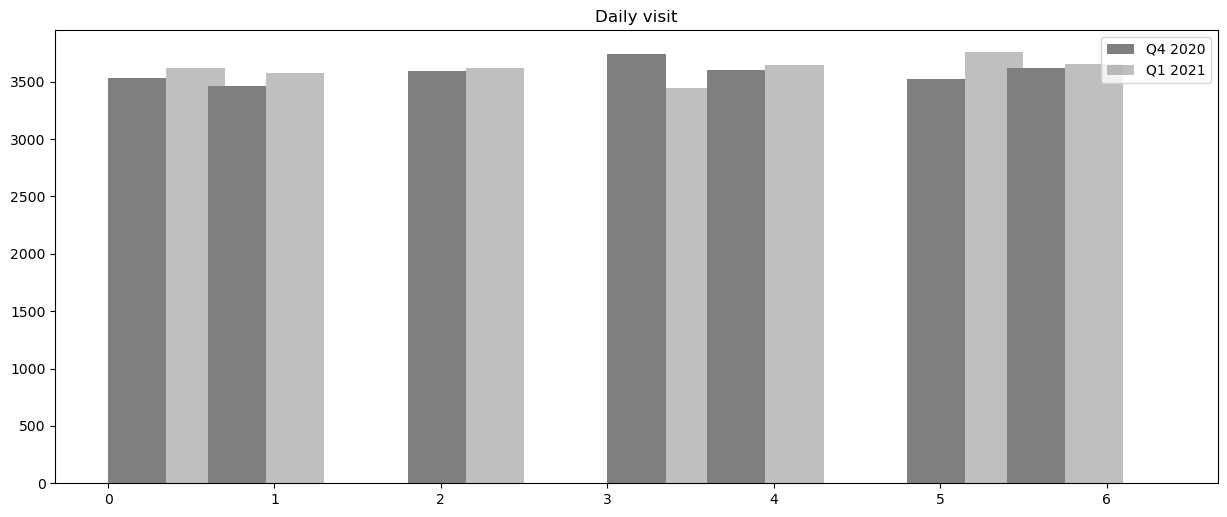

In [14]:
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})

x1 = dfQ4['dayOfWeek']
x2 = dfQ1['dayOfWeek']
kwargs = dict(alpha=0.5)

plt.hist(x1, **kwargs, label='Q4 2020', width=0.35, color='black')
plt.hist(x2 + 0.35, **kwargs, label='Q1 2021', width=0.35, color='grey')
plt.gca().set(title='Daily visit')
plt.legend();

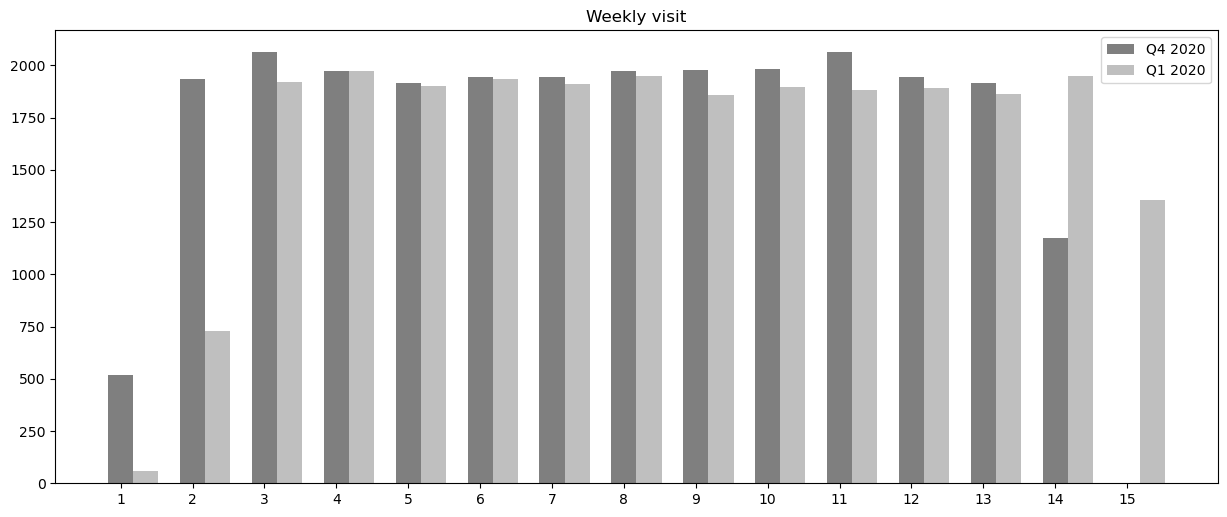

In [15]:
weeklyVisitQ4 = dfQ4[['weekOfYear']]
weeklyVisitQ4 = weeklyVisitQ4.sort_values(by=['weekOfYear']).reset_index()
weeklyVisitQ4 = weeklyVisitQ4.reset_index()
weeklyVisitQ4 = weeklyVisitQ4['weekOfYear'].value_counts().reset_index()
weeklyVisitQ4 = weeklyVisitQ4.sort_values(by=['index'])
weeklyVisitQ4.rename(columns={'index': 'weekNumber', 'weekOfYear': 'count'}, inplace=True)
weeklyVisitQ4 = weeklyVisitQ4.reset_index()
weeklyVisitQ4['week'] = weeklyVisitQ4.index + 1

weeklyVisitQ1 = dfQ1[['weekOfYear']]
weeklyVisitQ1 = weeklyVisitQ1.sort_values(by=['weekOfYear']).reset_index()
weeklyVisitQ1 = weeklyVisitQ1.reset_index()
weeklyVisitQ1 = weeklyVisitQ1['weekOfYear'].value_counts().reset_index()
weeklyVisitQ1 = weeklyVisitQ1.sort_values(by=['index'])
weeklyVisitQ1.rename(columns={'index': 'weekNumber', 'weekOfYear': 'count'}, inplace=True)
weeklyVisitQ1 = weeklyVisitQ1.reset_index()
weeklyVisitQ1['week'] = weeklyVisitQ1.index + 1
weeklyVisitQ1

x1_axis_labels = weeklyVisitQ1['week'].tolist()
y1_axis_values = weeklyVisitQ1['count'].tolist()
x2_axis_labels = weeklyVisitQ4['week'].tolist()
y2_axis_values = weeklyVisitQ4['count'].tolist()

y1_pos=np.arange(len(x1_axis_labels))
y2_pos=np.arange(len(x2_axis_labels))

kwargs = dict(alpha=0.5)

plt.bar(y1_pos + 0, y1_axis_values, **kwargs, width=0.35, color = 'black', label='Q4 2020')
plt.bar(y2_pos + 0.35, y2_axis_values, **kwargs, width=0.35, color = 'grey', label='Q1 2020')

plt.xticks(y1_pos, x1_axis_labels)
plt.xticks(y2_pos, x2_axis_labels)

plt.legend(loc='best')
plt.title("Weekly visit")
plt.show()

## Click stream comparison of the two quarters
The below section consists of the table printouts of the clickstreams

In [16]:
clickstream1 = dfPQ1_1.merge(dfPQ4_1, on='concat_ws(> , collect_list(pageActivity))')
clickstream1.rename(columns={
    'concat_ws(> , collect_list(pageActivity))': 'Page & Action',
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
pd.set_option('display.max_colwidth', -1)
clickstream1.head(25)

,Page & Action,Q1 2021,Q4 2020
0,Page-https://en.wikipedia.org/wiki/Bookkeeping,1370,1362
1,Page-https://en.wikipedia.org/wiki/Financial_technology,1366,1372
2,Event-https://en.wikipedia.org/wiki/Main_Page,1366,1357
3,Event-https://en.wikipedia.org/wiki/Bookkeeping,1364,1313
4,Event-https://en.wikipedia.org/wiki/Accounting,1357,1440
5,Event-https://en.wikipedia.org/wiki/Financial_services,1349,1274
6,Event-https://en.wikipedia.org/wiki/Financial_technology,1349,1307
7,Event-https://en.wikipedia.org,1342,1292
8,Page-https://en.wikipedia.org,1339,1426
9,Page-https://en.wikipedia.org/wiki/Accounting,1335,1330


In [17]:
clickstream2 = dfPQ1_1a.merge(dfPQ4_1a, on='concat_ws(> , collect_list(page))')
clickstream2.rename(columns={
    'concat_ws(> , collect_list(page))': 'Page',
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
pd.set_option('display.max_colwidth', -1)
clickstream2.head(25)

,Page,Q1 2021,Q4 2020
0,https://en.wikipedia.org/wiki/Bookkeeping,2734,2675
1,https://en.wikipedia.org/wiki/Financial_technology,2715,2679
2,https://en.wikipedia.org/wiki/Accounting,2692,2770
3,https://en.wikipedia.org,2681,2718
4,https://en.wikipedia.org/wiki/Main_Page,2673,2671
5,https://en.wikipedia.org/wiki/Financial_services,2634,2656
6,https://en.wikipedia.org/wiki/Financial_technology> https://en.wikipedia.org/wiki/Bookkeeping,108,84
7,https://en.wikipedia.org/wiki/Bookkeeping> https://en.wikipedia.org/wiki/Financial_services,108,78
8,https://en.wikipedia.org/wiki/Financial_services> https://en.wikipedia.org/wiki/Financial_services,107,105
9,https://en.wikipedia.org/wiki/Financial_technology> https://en.wikipedia.org/wiki/Financial_services,107,94


In [18]:
clickstream3 = dfPQ1_1b.merge(dfPQ4_1b, on='concat_ws(> , collect_list(activity_og))')
clickstream3.rename(columns={
    'concat_ws(> , collect_list(activity_og))': 'Action',
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
pd.set_option('display.max_colwidth', -1)
clickstream3.head(25)

,Action,Q1 2021,Q4 2020
0,Event,8127,7983
1,Page,8002,8186
2,Page> Page,847,818
3,Page> Event,839,810
4,Event> Page,808,790
5,Event> Event,783,722
6,Event> Page> Event,97,96
7,Page> Page> Page,96,67
8,Page> Event> Page,95,91
9,Page> Event> Event,91,85


In [19]:
clickstream4 = dfPQ1_1c.merge(dfPQ4_1c, on='page')
clickstream4.rename(columns={
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
pd.set_option('display.max_colwidth', -1)
clickstream4.head(10)

,page,Q1 2021,Q4 2020
0,https://en.wikipedia.org/wiki/Financial_services,2137,1986
1,https://en.wikipedia.org,2059,2039
2,https://en.wikipedia.org/wiki/Main_Page,2086,2135
3,https://en.wikipedia.org/wiki/Accounting,2092,2147
4,https://en.wikipedia.org/wiki/Financial_technology,2125,2030
5,https://en.wikipedia.org/wiki/Bookkeeping,2106,2051


## Highlights
From all of the above calculations, the below section covers the creation of the highlight section.

First, the change of amount is calculated.

In [20]:
changeInAmount = (persona1['Magnitude_Q4'].values[0] - persona1['Magnitude_Q1'].values[0])
changeInPercentage = (persona1['MagnitudeInPercentage_Q4'].values[0] - persona1['MagnitudeInPercentage_Q1'].values[0])

changeInAmount = changeInAmount.astype(str)
changeInPercentage = changeInPercentage.astype(int)


Then, the starting point of the user journey is studied. Only the two main pages were included in the study though.
<br><Br>
    <b>Important</b>: The amount of columns on line one key below are dependent on the dataset and need to be manually updated. When an error occured, try to add or remove columns. When adding the columns, add the numbers accordingly ('five', 'six', etc.)

In [21]:
clickstream2[['One','Two', 'Three', 'Four']] = clickstream2.Page.str.split(">",expand=True,)
start_main = clickstream2[clickstream2['One'] == 'https://en.wikipedia.org/wiki/Main_Page']
start_home = clickstream2[clickstream2['One'] == 'https://en.wikipedia.org']

start_main_index = start_main.index
start_main_index = len(start_main_index)
start_home_index = start_home.index
start_home_index = len(start_home_index)

start_home_differences = (start_home['Q1 2021'].sum()) - (start_home['Q4 2020'].sum())
start_main_differences = (start_main['Q1 2021'].sum()) - (start_main['Q4 2020'].sum())

Then, the list of pages of which activity happened the most is calculated.

In [22]:
activity_sorted = clickstream4.sort_values('Q1 2021')
activity_sorted = activity_sorted['page'].tolist()
activity_sorted

['https://en.wikipedia.org',
 'https://en.wikipedia.org/wiki/Main_Page',
 'https://en.wikipedia.org/wiki/Accounting',
 'https://en.wikipedia.org/wiki/Bookkeeping',
 'https://en.wikipedia.org/wiki/Financial_technology',
 'https://en.wikipedia.org/wiki/Financial_services']

Lastly, put the 3 highest information of the visit history on list to be presented in the highlights.

In [23]:
hour_q1 = dfQ1['visitByTheHour'].value_counts()
hour_q1 = pd.DataFrame(hour_q1)
hour_q1 = hour_q1.sort_values('visitByTheHour', ascending=False).reset_index()
hour_q1 = hour_q1.iloc[:3]
hour_q1 = (hour_q1['index']).tolist()

day_q1 = dfQ1['dayOfWeek'].value_counts()
day_q1 = pd.DataFrame(day_q1)
day_q1 = day_q1.sort_values('dayOfWeek', ascending=False).reset_index()
day_q1 = day_q1.iloc[:3]
day_q1 = (day_q1['index'])
day_q1.rename({0: 'Sunday', 
               1: 'Monday',
               2: 'Tuesday', 
               3: 'Wednesday',
               4: 'Thrusday', 
               5: 'Friday',
               6: 'Saturday'}, inplace=True)
day_q1 = pd.DataFrame(day_q1)
day_q1 = day_q1.reset_index()
day_q1 = day_q1['level_0'].tolist()

week_q1 = weeklyVisitQ1.sort_values('count', ascending=False)
week_q1 = week_q1.iloc[:3]
week_q1 = (week_q1['week']).tolist()

The below are the story line created for the highlight, inserted with variables from the calculation above.

In [24]:
print('In the new quarter, the persona size has a change in the amount of', changeInAmount, ' and thus make the persona size change ', changeInPercentage, '%.')
print(' ')
print('As Wikipedia has both main page and homepage. Understanding the start of user journey is important.')
print('This quarter', start_home_index, ' amount of the users started their jouney through the homepage. A change of ', start_home_differences, ' from last quarter.')
print('Further', start_main_index, ' amount of the users started their jouney through the main page. A change of ', start_main_differences, ' from last quarter.')
print(' ')
print('The below are sorted list of the pages with the most activities (highest - lowest):')
print(activity_sorted)
print(' ')
print('Lastly, this quarter, the users mostly visit the platform on ', day_q1, 'at these times:', hour_q1)
print('The users also mostly visit the platform at these weeks:', week_q1)



In the new quarter, the persona size has a change in the amount of -250  and thus make the persona size change  0 %.
 
As Wikipedia has both main page and homepage. Understanding the start of user journey is important.
This quarter 41  amount of the users started their jouney through the homepage. A change of  -35  from last quarter.
Further 43  amount of the users started their jouney through the main page. A change of  -26  from last quarter.
 
The below are sorted list of the pages with the most activities (highest - lowest):
['https://en.wikipedia.org', 'https://en.wikipedia.org/wiki/Main_Page', 'https://en.wikipedia.org/wiki/Accounting', 'https://en.wikipedia.org/wiki/Bookkeeping', 'https://en.wikipedia.org/wiki/Financial_technology', 'https://en.wikipedia.org/wiki/Financial_services']
 
Lastly, this quarter, the users mostly visit the platform on  ['Sunday', 'Monday', 'Tuesday'] at these times: [17, 22, 5]
The users also mostly visit the platform at these weeks: [3, 11, 10]
